# Data Preprocessing

In [1]:
import cv2 
import os
import tensorflow as tf 
import numpy as np 
import keras 
import string
import time 
import random
import matplotlib
import matplotlib.pyplot as plt 
#import torchvision 
#import torch.nn as tnn 
import glob 
from keras import utils
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout 
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.applications import VGG16
import sklearn
#import theano 




data_path = "/Users/pranavpradhan/Documents/SLR/Dataset/asl_alphabet_train"

2023-08-16 18:38:08.642899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
labels = []
labels.extend(list(string.ascii_uppercase))
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [3]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join("/Users/pranavpradhan/Documents/SLR/Dataset/asl_alphabet_train", label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()


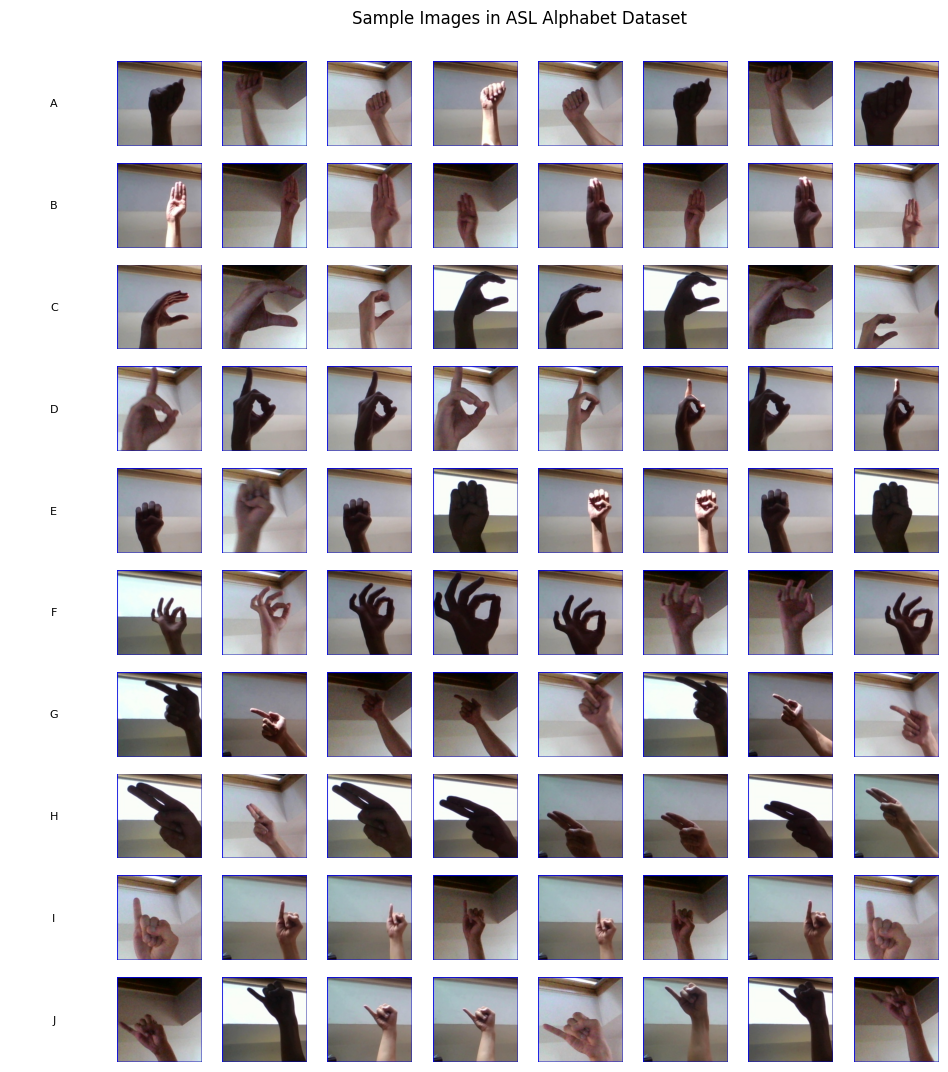

In [4]:
sample_images(labels[:10])


In [5]:
images = []
image_labels = []
size = (32, 32)
index = -1

for folder in os.listdir(data_path):
    if folder.startswith('.'):
        continue  # Skip hidden files/folders, e.g., ".DS_Store"
    
    index += 1
    folder_path = os.path.join(data_path, folder)

    if not os.path.isdir(folder_path):
        continue  # Skip non-directory files
    
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        temp_img = cv2.imread(image_path)

        if temp_img is not None:
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            image_labels.append(index)

images = np.array(images)
images = images.astype('float32') / 255.0
image_labels = utils.to_categorical(image_labels)

In [6]:
print(len(images))


87000


In [10]:
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(data_path, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

NameError: name 'pd' is not defined

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

def split_images(image_path, labels, test_size=0.15, val_size=0.15, random_state=None):

   
   
    X_train, X_test, y_train, y_test = train_test_split(
        image_path, labels, test_size=test_size, random_state=random_state
    )

    # Calculate the proportion of the validation set based on the original dataset size
    val_size = val_size / (1 - test_size)
    
    # Split the train set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_state
    )
    print('Loaded', len(X_train),'images for training,','Train data shape =', X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =', X_test.shape)
    print('Loaded', len(X_val),'images for validation','Validation data shape =', X_val.shape)
 
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = split_images(images, image_labels) 

Loaded 60900 images for training, Train data shape = (60900, 32, 32, 3)
Loaded 13050 images for testing Test data shape = (13050, 32, 32, 3)
Loaded 13050 images for validation Validation data shape = (13050, 32, 32, 3)


In [9]:
print((len(X_train) + len(X_val) + len(X_test)))

87000


In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = split_images(metadata["image_path"], metadata["label"]) 

NameError: name 'metadata' is not defined

# Building VGG16 imagenet model

In [4]:
batch_size = 64
img_height = 64 
img_width = 64 
epochs = 10 
channels = 3 
# Generate the model
model = Sequential()
# Layer 1: Convolutional
model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3),
                 padding='same', activation='relu'))
# Layer 2: Convolutional
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 3: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 4: Convolutional
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 5: Convolutional
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 6: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 7: Convolutional
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 8: Convolutional
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 9: Convolutional
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 10: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 11: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 12: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 13: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 14: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 15: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 16: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 17: Convolutional
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
# Layer 18: MaxPooling
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))



# Layer 19: Flatten
model.add(Flatten())
# Layer 20: Fully Connected Layer
model.add(Dense(units=512, activation='relu'))


# Layer 22: Softmax Layer


model.add(Dense(units=29, activation='softmax'))


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Check model summary
print(model.summary())








Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

In [10]:
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3)))


In [11]:
model.add(Flatten())

# Layer 21: Fully Connected Layer


model.add(Dense(units=512, activation='relu'))
# Layer 22: Softmax Layer


model.add(Dense(units=29, activation='softmax'))


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Check model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 29)                14877     
                                                                 
Total params: 14992221 (57.19 MB)
Trainable params: 14992221 (57.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [13]:
batch_size = 128
img_height = 64 
img_width = 64 
epochs = 3
channels = 3


history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), shuffle=True, verbose=1)

Epoch 1/3
476/476 [==============================] - 1321s 3s/step - loss: 0.3024 - accuracy: 0.8990 - val_loss: 0.1751 - val_accuracy: 0.9389
Epoch 2/3
476/476 [==============================] - 1664s 3s/step - loss: 0.0545 - accuracy: 0.9814 - val_loss: 0.0348 - val_accuracy: 0.9884
Epoch 3/3
476/476 [==============================] - 2894s 6s/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0435 - val_accuracy: 0.9843


In [14]:
# Save model architecture to JSON file
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights('model_weights.h5')

print('Model and training history saved')

Model and training history saved
